# From Notebook 2 we know that specific hyperparameters

Leaf size = 1 

p = 1 (Manhattan distance)

Nieghbour number = 7

From this we can try doing the regessor object on data that has specific variables removed, by doing this we can understand which variables are the most important to the accuracy of the regressor.

In [2]:
# import packages
%matplotlib nbagg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.widgets

from matplotlib.ticker import MaxNLocator
from matplotlib.widgets import RadioButtons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

# Importing old classes

Here we reimport old classes that will be used in the functions below. Namely preprocessor, regressor and postplotter.

In [3]:
# class to preprocess data

class Preprocessor:
    
    # initalise self with data needed to be preproccessed
    def __init__ (self, data):
        self.data = data

    def encode(self, kind: str, c_name:str ):
        """encoder(kind:str, c_name)
           kind  is either onehot or label
           c_name is the name of the column that will be encoded
           """
        # update self.data with the appropriate encoder
        assert kind in ['onehot', 'label']
        self.kind = kind
          
        # do one hot encoder
        if self.kind == 'onehot':
            classes = set(self.data[c_name])
            for cls in classes:
                self.data[cls] = self.data[c_name].apply(lambda x: 1 if x == cls else 0)
            del self.data[c_name]
            return self.data
            
        # do label encoder
        else:
            classes = set(self.data[c_name])
            values = {list(classes)[i]: i for i in range(len(classes))}
            self.data[c_name] = self.data[c_name].apply(lambda x: values[x])

        return self.data
    
    def scale(self, kind: str, c_name: str):
        """scale(kind:str, c_name)
           kind  is either minmax or std
           c_name is the name of the column that will be scaled"""
            
        # overwrites columns in self.data with 
        # scaled versions based on kind parameter
        
        # make sure kind is either minmax or std
        assert kind in ['minmax', 'std']

        # start with minmax
        if kind == 'minmax':
            min_value = min(self.data[c_name])
            max_value = max(self.data[c_name])
            diff = max_value - min_value
            self.data[c_name] = self.data[c_name].apply(lambda x: (x - min_value) / diff)
            
            return self.data
        
        # then do standard scaler
        elif kind == 'std':
            mean = self.data[c_name].mean()
            std = self.data[c_name].std()
            self.data[c_name] = self.data[c_name].apply(lambda x: (x - mean) / std)
        else:
            print('Invalid scaler, check parameters before proceeding with ML')
            
        return self.data

    # function to remove entire column of data
    def remove (self, c_name):
        del self.data[c_name]
        return self.data
     
    # function to replace unknown data with mean, median or dropping it
    def replace (self, c_name, kind):
        assert kind in ['mean', 'median','drop']
        
        if kind == 'mean':
            mean_value = self.data[c_name].mean()
            self.data[c_name] = self.data[c_name].fillna(mean_value)
            return self.data
        
        if kind == 'median':
            median_value = self.data[c_name].median()
            self.data[c_name] = self.data[c_name].fillna(median_value)
            return self.data
            
        else:
            self.data = self.data.dropna().reset_index(drop = True)
            return self.data

In [4]:
def load(fname: str, cv: str) -> tuple:
    # basic spliter for now
    """Loads 2 column data from a CSV file with 2 columns, x and y"""

    # read data
    data = pd.read_csv(fname)
    y_column = 'stroke'
    
    # get training data
    X_columns = list(data.columns)
    X_columns.remove(y_column)
    X = data[X_columns].to_numpy()
    y = data[y_column].to_numpy()

    # splitting calling the scikit split method of each cross validator
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    # return all
    return X, y, X_train, y_train, X_test, y_test

class Regressor:
    """Container for analysing different metrics for a single regression class"""
    def __init__(self, cls, fname: str, cv, cls_kwargs: dict = {}, cv_kwargs: dict = {} ):
        # construct regressor object
        self.regressor = cls(**cls_kwargs)
        self.cv = cv(**cv_kwargs)

        # use load function
        # where cv is a splitting class i.e kFold()
        self.X, self.y, self.X_train, self.y_train, self.X_test, self.y_test = load(fname, self.cv)

        # fit data
        self.regressor.fit(self.X_train, self.y_train)

        # get predicted data
        self.y_pred = self.regressor.predict(self.X_test)

    def metric(self, cls, **kwargs) -> float:
        """Takes a sklearn.metrics class and returns the score of the regressor object"""

        # use the metric class to get a score
        return cls(self.y_test, self.y_pred)
    
    def predict(self, X_new):
        y = self.regressor.predict(X_new)
        return y
    

In [11]:
class postplotter:
    
    #initalise self with regressor object and test data
    def __init__ (self, x_test, y_test, y_pred):
        self.y_test = y_test
        self.y_pred = y_pred
        self.x_test = x_test
        
    # plots confusion matrix and gives FR values
        
    def confmatrix (self, title: str):
    
        fig, ax = plt.subplots()
        array = np.zeros((2, 2))

        for i, correct_value in enumerate(self.y_test):
            predicted_value = int(abs(np.round(self.y_pred[i])))
            array[predicted_value, correct_value] += 1
        


        # plot array as image
        im = ax.imshow(array, origin='lower', cmap='viridis')

        # label axes
        ax.set_xlabel('Real Type')
        ax.set_ylabel('Predicted Type')

        # add colorbar
        plt.colorbar(im)
        
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        for i in range(2):
            for j in range(2):

                # leave colour as white as the default
                color = 'black'
                if (i == 2 and j != 2):

                    # when overdose happened but wasn't predicted, changed colour
                    # to red if it is not 0
                    if array[i, j] == 0:
                        color = 'black'

                    else:
                        color = 'black'

                # set colour to black for the light coloured square
                # this is done after plotting once
                elif i == 1 and j == 1:
                    color = 'black'

                # add text with correct colour
                ax.text(j, i, array[i, j], ha='center', va='center', color=color)
        
        #sets axis title
        ax.set_title(title, fontsize=15)

        
        #calculates F1, P and R values
        R = (array[1,1]/(array[1,1]+array[1,0]))*100
        
        if (array[1,1]+array[0,1]) != 0:
            P = (array[1,1]/(array[1,1]+array[0,1]))*100
            F1 = 2*P*R/(P+R)
            confresults = pd.DataFrame({'Precision P': P, 'F-score F1': F1, 'Recall R': R }, index=[0])

        else:
            confresults = pd.DataFrame({'Precision P': 'N/A', 'F-score F1': 'N/A', 'Recall R': R }, index=[0])
            print("P and F1 could not be calculated due to 0 total correct guesses")

        print(confresults.to_string(index=False))
        
    def scorer(self):
        """creates score attributes of this class for F1, R and P"""
        array = np.zeros((2, 2))

        for i, correct_value in enumerate(self.y_test):
            predicted_value = int(abs(np.round(self.y_pred[i])))
            array[predicted_value, correct_value] += 1
        
        self.R = (array[1,1]/(array[1,1]+array[1,0]))*100
        
        if (array[1,1]+array[0,1]) != 0:
            self.P = (array[1,1]/(array[1,1]+array[0,1]))*100
            self.F1 = 2*self.P*self.R/(self.P+self.R)
        else:
            print("P and F1 could not be calculated due to 0 total correct guesses")
    


# Column removal

Here we removed columns from the preprocessed data, to be compared.

In [6]:
# Generate csvs for see effect of removing each column using radio buttons
# read preprocessed data to delete columns to used in the final cell, hence output to csv

# load preporcessed data
data = pd.read_csv('data/splits/split21.csv')

# run loop over names
for name in data.columns:
    
    # generate class using copy of data so it can be reused in loop
    datap = Preprocessor(data.copy())
    # remove specific data column
    datare = datap.remove(name)
    # output to csv in diff file 
    datare.to_csv(f'data/data_removed/{name}_removed_split21.csv', index=False)
# This is the final preprocessd data. CSVs have been generated with each column and the stroke column
data

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke
0,0.816895,0,1,0,0.801265,0.301260,0,1
1,0.975586,0,1,0,0.234512,0.254296,3,1
2,0.597168,0,0,0,0.536008,0.276060,1,1
3,0.963379,1,0,0,0.549349,0.156930,3,1
4,0.987793,0,0,0,0.605161,0.214204,0,1
...,...,...,...,...,...,...,...,...
415,0.426270,0,0,0,0.123627,0.162658,3,0
416,0.487305,0,0,1,0.205244,0.158076,2,0
417,0.450684,0,0,1,0.320469,0.240550,3,0
418,0.401855,0,0,0,0.453421,0.242841,3,0


# Score generation

Here we use the confusion matrix function to get the scores of the data. Namely, percision, recall and F1 score. This is complied into a list for plotting.

In [13]:
# import full data set
data = pd.read_csv('data/splits/split21.csv')

# create kwargs dictionary
cls_kwargs = { "n_neighbors":7 , "leaf_size":1 , "p":1 }

# create scores dictionary to store plot data
scores = {}

# use newly found optimised hyperparameters to make new regressor item
full_reg = Regressor(KNeighborsClassifier,'data/splits/split21.csv', StratifiedKFold, cls_kwargs)
plot_full = postplotter(full_reg.X_test, full_reg.y_test, full_reg.y_pred)
# append to score with title 'full'
plot_full.scorer()
scores['full'] = plot_full.P, plot_full.F1, plot_full.R

# cycle over all removed column datasets
for name in data.columns:
    # don't remove stroke data
    if name == "stroke":  
        pass
    else:
        # make a temporary regressor item with the removed csv file
        temp_reg = Regressor(KNeighborsClassifier,f'data/data_removed/{name}_removed_split21.csv', StratifiedKFold)
        plot_temp = postplotter(temp_reg.X_test, temp_reg.y_test, temp_reg.y_pred)
        plot_temp.scorer()
        # append to score with title of removed data
        scores[f'{name}'] = plot_temp.P, plot_temp.F1, plot_temp.R

# Interactive graph

Here we make an interactive graph for the user to see what parameters of the data matter most.

<IPython.core.display.Javascript object>


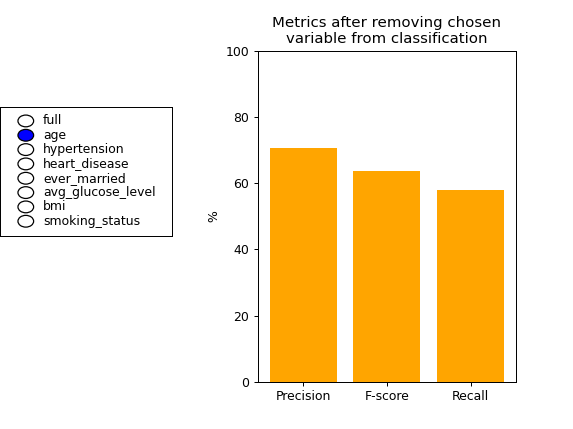

In [14]:
# generate and move subplot
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.45)

# create colour dictionary to allow changing of bar chart colour.
color = ['blue','orange','green','red','m','pink','cyan','gray']
colors = {}
for  i , name in enumerate (scores):
    colors[name] = color[i]

# define bottom of the the bar chart
objects = ('Precision' , 'F-score' ,  'Recall' )
y_pos = np.arange(len(objects))

# makes y bar go to 100%
ax.set_ylim([0,100])
ax.set_ylabel('%')

# pull from dictionary for inital
performance = scores["full"]

# plot the bar chart
ax.bar(y_pos, performance, align='center')

# change ticks to titles
plt.xticks(y_pos, objects)
ax.set_title('Metrics after removing chosen\nvariable from classification')


# create radio box
radio_ax = plt.axes( [0.0, 0.45, 0.3, 0.3],  facecolor='#ffffff')
# create radio buttons
radio = RadioButtons( radio_ax, scores.keys())

# callback function to run when buttons are pressed
def callback(label: str):
    
    # clear plot
    ax.clear()
    
    # reset all objects
    ax.set_ylim([0,100])
    ax.set_ylabel('%')
    performance = scores[label]
    ax.set_xticks(y_pos)
    ax.set_xticklabels(objects)
    
    # plot new data
    ax.bar(y_pos, performance, align='center', color = colors[label])
    ax.set_title('Metrics after removing chosen\nvariable from classification')

# run on radio click
radio.on_clicked(callback)

# show plot
plt.show()

# Key findings

From the interactive graph we can see that age is highly relied upon by the regressor, this is expected as it is known that stroke chance increases with age.
Moverover, hypertension and heart disease give the same output, this is likely due to them being closely related to each other. And hence effect the regressor the same way when removed.
Marriage removal increases precision but reduces recall, calling in a similar F-score.
All avg glucose level, bmi and smoking status reduce all 3 scores of the data.

The fact that removing any variable reduces the predictivity of the regresssor suggests that our data selection was correct if not over zealous, as the best regressor is made from our entire dataset.

## Final implementation of the classifier on full data set 
Our classifier, now optimised with the best arguments and trained on a segment of our data was implemented on the full data, and returned a high precision. The issue is that on this data set it over-predicts a lot of strokes and still doesn't overpredict enough to encompass all the true stroke results. Ideally we could improve this by overfitting such that we get no false negatives, this would mean nobody would have been told they wouldn't have a stroke then end up having a stroke. However finding the right balance between overpredicting false negatives and false positives is a moral argument, and decreasing the amount of false negatives we have would increase the number of false positives. 

Overall our classifier does a good job at predicting whether somebody will have a stroke or not, as seen by the confusion matrix plotted below. 

<IPython.core.display.Javascript object>


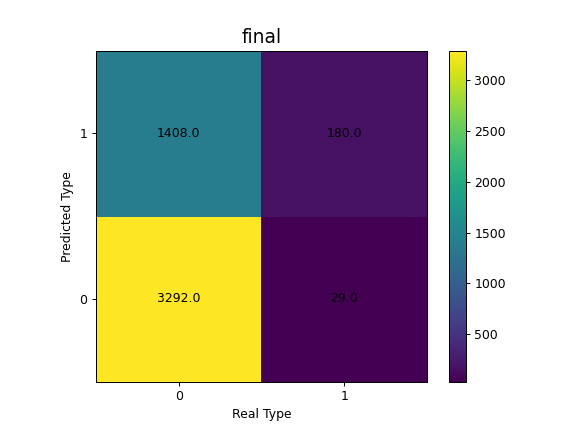

 Precision P  F-score F1  Recall R
   86.124402   20.033389 11.335013


In [15]:
final_reg = Regressor(KNeighborsClassifier,'data/splits/split21.csv', StratifiedKFold, cls_kwargs)
data = pd.read_csv('data/preprocessed-healthcare-dataset-stroke-data.csv')
y_column = 'stroke'
X_columns = list(data.columns)
X_columns.remove(y_column)
X = data[X_columns].to_numpy()
y = data[y_column].to_numpy()
new_y = final_reg.predict(X)
plot_full = postplotter(X, y, new_y)
# append to score with title of removed data
plot_full.confmatrix('final')